In [2]:
#%matplotlib inline
%matplotlib widget


In [3]:
import cv2 as cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
from ipywidgets import HBox, Textarea, interact
import time

def l2n(x):
    return np.array(x)

In [4]:
def parseCircles(circles):
    x = []
    y = []
    r = []
    for i in range(len(circles)):
        x.append(circles[i,0,0])
        y.append(circles[i,0,1])
        r.append(circles[i,0,2])
        
    x,y,r = l2n(x), l2n(y),l2n(r)
    return x,y,r

In [5]:
def preProcessFrame(frame):
    #blur and grayout a frame
    
    # Convert to grayscale.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      
    # Convert to HSV and extract the saturation channel
    #sat = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)[:,:,0]

    # median filter
    #median = cv2.medianBlur(gray, 3)
    #gray_blurred = median
    # Blur using 3 * 3 kernel.
    blurSize = 10#5
    gray_blurred = cv2.blur(gray, (blurSize, blurSize))
    
    return gray_blurred

def detectCircles(frame,minRadius,maxRadius,param1=30,param2=25):
    
    minDist = int(2.5*maxRadius)
    dp = 1
    # Apply Hough transform on the blurred image.
    circles = cv2.HoughCircles(frame, 
                cv2.HOUGH_GRADIENT,dp, minDist, param1 = param1,
                param2 = param2, minRadius = minRadius, maxRadius = maxRadius)

    return circles
    
def captureFrame(video,frame_id):
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = video.read()
    if ret:
        return frame
    else:
        return ret

def drawCircles(circles,ax ):
    if circles is not None:  
    # Convert the circle parameters a, b and r to integers.
    #detected_circles = np.uint16(np.around(detected_circles))
    #fig, ax = plt.subplots() 
        for pt in circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]
            circle = plt.Circle((a, b), r, color='r',fill=False)
            ax.add_patch(circle)
            #ax.imshow(frame, cmap = 'gray')

def drawCirclesDf(df,ax ):
    
    
    for index, row in df.iterrows():
        x,y,r = row.x,row.y,row.r
        circle = plt.Circle((x, y), r, color='r',fill=False)
        ax.add_patch(circle)

def circlesToDataFrame(circles,frameNum):    
    x,y,r = parseCircles(circles)
    data = {'frame':[int(frameNum)]*len(circles),'x':x,'y':y,'r':r}
    dft = pd.DataFrame(data = data)
    
    return dft


def cropImage(img,x0,y0,width,height):
    return img[y0:y0+height,x0:x0+width,:]
'''def cropImage(img,x0,y0,width,height):
    d = len(img.shape)
    if d==2: #grayscale
        return img[y0:y0+height,x0:x0+width]
    elif d==3: #rgb
        return img[y0:y0+height,x0:x0+width,:]
'''

'def cropImage(img,x0,y0,width,height):\n    d = len(img.shape)\n    if d==2: #grayscale\n        return img[y0:y0+height,x0:x0+width]\n    elif d==3: #rgb\n        return img[y0:y0+height,x0:x0+width,:]\n'

### Experimental settings

In [6]:
arenaSizePixels = 1090 # [pixels]
arenaSizeCm = 150 # [cm]

### Load experiments summary table

In [1]:
expSumFileName = 'transportExpSumMaster.csv'
expSum = pd.read_csv(expSumFileName,index_col=0)

NameError: name 'pd' is not defined

## Locating params 

In [7]:
x0,y0 = 310,0
width0,height0 = 1160,1080

#frameNum = 1500
threshMin = 250
threshMax = 900

param1 = 43#100#25#35#30#25#25
param2 = 19#35

#frameSkip = 25


#### filter a sub-set of experiments

In [8]:
expSum = experiments[(experiments['bots']==21)]


### Batch locate - will take a while

In [12]:
exp21.iterrows()

<generator object DataFrame.iterrows at 0x0000023420B144A0>

In [11]:
globalStartTime = time.time()

locatedFileNames = []


for index,row in (exp21.iterrows()):
    fileName  =row.path
    print('Locating a circle in ' + fileName);
    video = cv2.VideoCapture(fileName)

    #get videos properties
    width  = int(video.get(cv2.CAP_PROP_FRAME_WIDTH ))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT ))
    fps = video.get(cv2.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
    frameCount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    pixelSize = arenaSizeCm/arenaSizePixels
    
    #defined according the column from the experiments table
    radiusMin = int(row.minCircleRadius)
    radiusMax = int(row.maxCircleRadius)
    
    
    data = {'frame':[],'x':[],'y':[],'r':[]}
    columns = ['frame','x','y','r']
    df = pd.DataFrame(data=data,columns=columns)

    boxSize = int(2*(2*radiusMax))
    wc,hc = boxSize,boxSize
    xc,yc = int(958-boxSize/2),int(548-boxSize/2)

    #xc,yc = 1184,634 frameMin=6710 #
    frameMin = 0 #0#frameCount-100
    frameMax = frameCount#frameCount#frameMin+1000#frameCount#frameMin+500#300#frameCount#minFrame+3*60*24
    #frameRange = range(frameMin,frameMax,frameSkip)
    
    
    startTime = time.time()
    video.set(cv2.CAP_PROP_POS_FRAMES, frameMin)
    ret = True
    
    while ret:
    
        #video.grab()#captureFrame(video,frameNum)
        ret, img = video.read()
        if(ret): #if succesfffuly read an image
            frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
            #imgRed = img[:,:,0]
            
            #For large images, locate a cropped window

            #imgCropped = cropImage(img,xc,yc,wc,hc)
            imgCropped =cropImage(img,300,0,1200,int(height))
            #Edge detection:
            imgE = cv2.Canny(imgCropped,threshMin,threshMax)
            #Find circles:
            circles = detectCircles(imgE,radiusMin, radiusMax,param1,param2)
            #If circle found, add to pandas Dataframe:
            if circles is not None:        
                dft = circlesToDataFrame(circles,frameNum)
                dft['x'] = dft['x']
                dft['y'] = dft['y']

                df = pd.concat([df,dft],ignore_index=True)
      #Save to CSV
    endTime = time.time()
    duration = endTime-startTime
    print('Locating ' + str(len(df)) + ' frames took ' + str(duration) + ' seconds.')
    
    #Save the pandas locating dataframe a CSV file at the video's location
    fileNameLoc = fileName+locatingFileNameSuffix
    df.to_csv(fileNameLoc)        
    locatedFileNames.append(fileNameLoc)
####################################linking#################################
    tp.quiet()
    search_range= 80
    memory= 1000
    minTrajLength =int(frameCount/4) #This is not the best condition (Matan)
    t = tp.link(df, search_range=search_range, memory=memory)
    t1=tp.filter_stubs(t,threshold=minTrajLength)
    path=fileName+locatingFileNameSuffix+'_linked.csv'
    t1.to_csv(path)
    
    
globalEndTime = time.time()
totalDuration = globalEndTime-globalStartTime
print('Locating ' + str(len(exp21)) + ' experiments took ' + str(totalDuration) + ' seconds.')

Locating a circle in D:\Eden\29_12_22\aligners_21_7cm\C0548.MP4
Locating 30504 frames took 871.7421371936798 seconds.
Locating a circle in D:\Eden\29_12_22\aligners_21_7cm\C0547.MP4
Locating 30540 frames took 904.9096937179565 seconds.
Locating a circle in D:\Eden\29_12_22\aligners_21_7cm\C0544.MP4
Locating 30372 frames took 897.5690805912018 seconds.
Locating a circle in D:\Eden\29_12_22\aligners_21_7cm\C0542.MP4
Locating 30516 frames took 916.2909636497498 seconds.
Locating a circle in D:\Eden\29_12_22\frontes_21_7cm\C0541.MP4
Locating 30564 frames took 921.6565761566162 seconds.
Locating a circle in D:\Eden\29_12_22\frontes_21_7cm\C0540.MP4
Locating 30048 frames took 892.1453411579132 seconds.
Locating a circle in D:\Eden\29_12_22\frontes_21_7cm\C0539.MP4
Locating 8256 frames took 243.51245832443237 seconds.
Locating a circle in D:\Eden\29_12_22\frontes_21_7cm\C0538.MP4
Locating 31068 frames took 909.2201135158539 seconds.
Locating a circle in D:\Eden\27_12_22\fronters-12cm\C0537.MP

### Save locating and linking filenames int exp21 dataframe
### In power cell, change fetching of locating/tracking from the table of experiments

In [13]:
print('Locating ' + str(len(exp21)) + ' experiments took ' + str(totalDuration) + ' seconds.')

Locating 43 experiments took 34963.81228399277 seconds.


In [15]:
print('There were ' + str(int(len(locatedFileNames))) + ' files located')
print('the total run duration was: ' + str(np.round(totalDuration/60/60,1)) +' hours')

There were 43 files located
the total run duration was: 9.7 hours


### Save experiments summary as a csv

In [35]:
expSum = exp21.copy()
linkingFileNames = []
locatingFileNames = []
for index,row in expSum.iterrows():
    originalVideoPath = row['path']
    locatingFileNames.append(originalVideoPath+locatingFileNameSuffix)    
    linkingFileNames.append(originalVideoPath+locatingFileNameSuffix+'_linked.csv')
                                
expSum['linkingFileName'] = linkingFileNames
expSum['locatingFileName'] = locatingFileNames

In [85]:
expSum['pixelSize [cm/pixel]'] = [pixelSize]*43

In [86]:
#exp21.to_csv('transportExpSum20230107bots21_.csv')
expSum.to_csv('transportExpSum20230305bots21_.csv')

# Plot all trajectories

In [43]:
expSum.columns

Index(['date', 'operator', 'bottype', 'stars', 'bots', 'passiveDiameter[cm]',
       'path', 'locatingFileName', 'minCircleRadius', 'maxCircleRadius', 'fps',
       'cpp', 'start_min', 'end_min', 'analysis stage', 'frames',
       'pixelSize [cm/pixel]', 'pixelSize_unbined [cm/pixel]', 'arenaSize[cm]',
       'turnOnTime [s]', 'comments', 'backedup', '130', 'production',
       'linkingFileName'],
      dtype='object')

In [59]:
for index,row in expSum.iterrows():
    fileNameLinked = row['linkingFileName']  
        
    df = pd.read_csv(fileNameLinked)#,index_col=0)
    #print(len(df.particle.unique()))

In [67]:
print(expSum.index)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42],
           dtype='int64')


In [75]:
int(1.9)

1

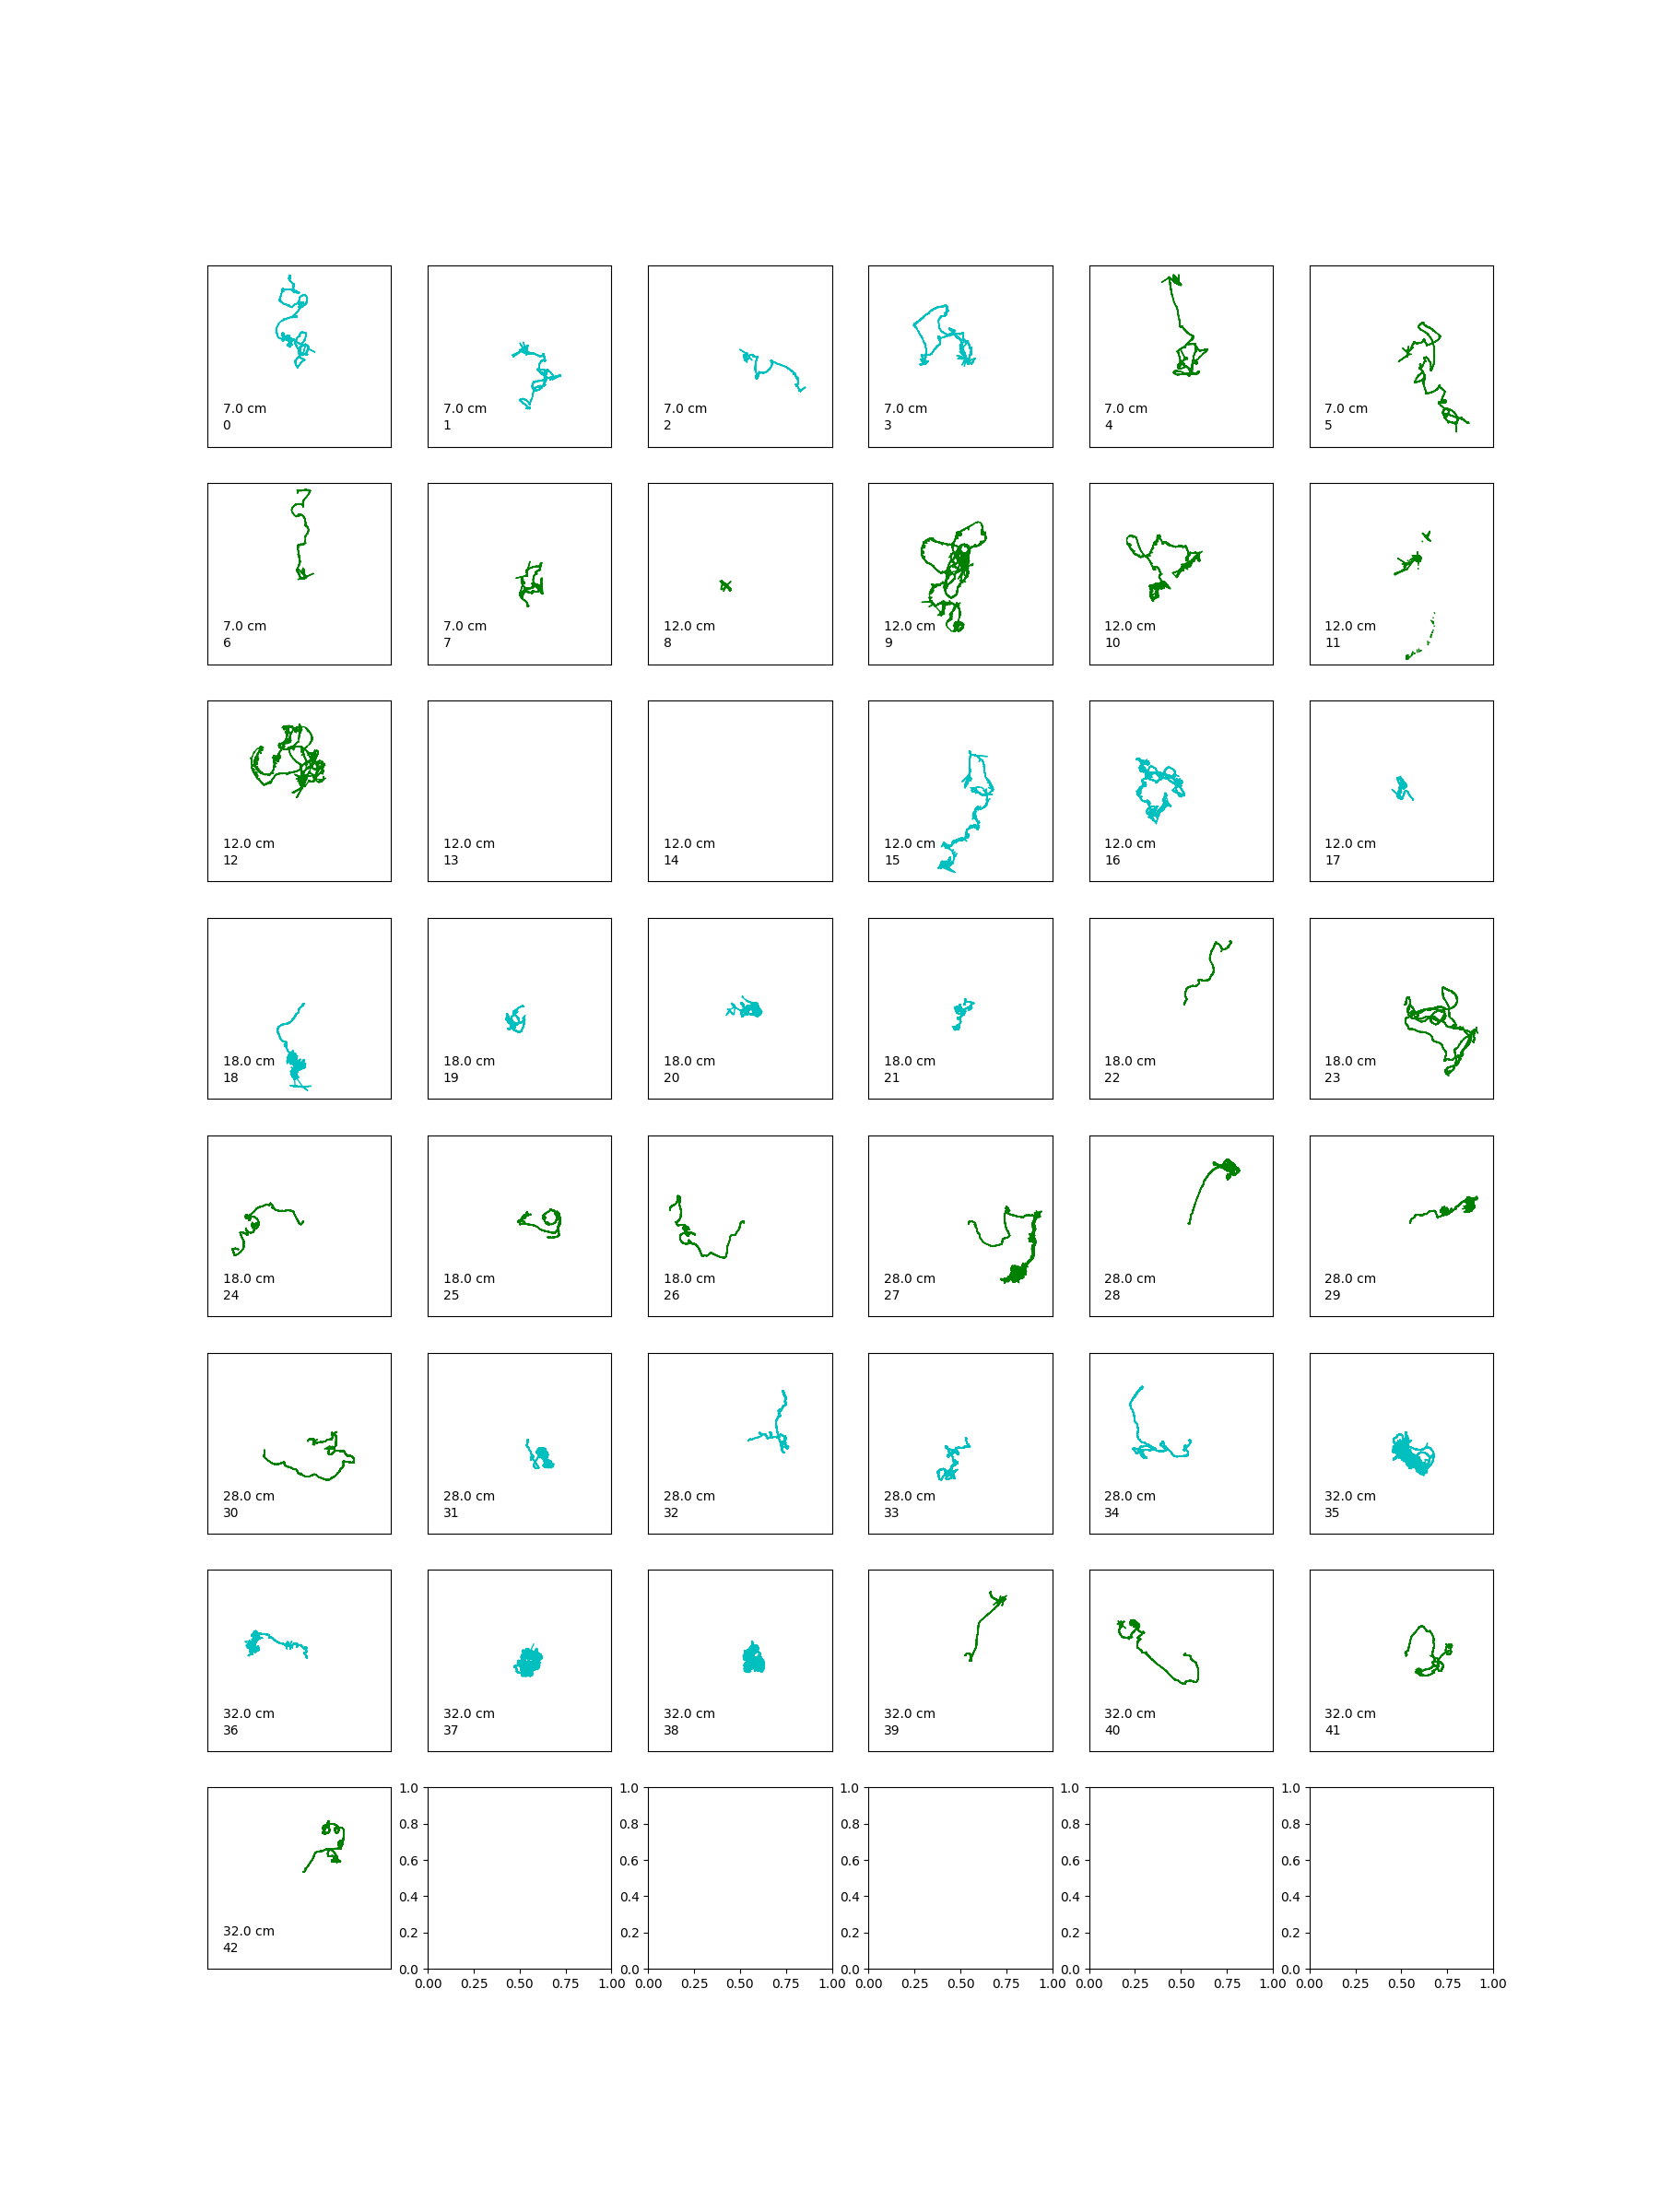

In [83]:
alignerColor = 'c'
fronterColor = 'g'
nrows = 8
ncols = 6
fig3,axs3 = plt.subplots(ncols=ncols,nrows=nrows,figsize=(18,24))
df=[]
for index,row in expSum.iterrows():
    botType = row.bottype
    passDiam = row['passiveDiameter[cm]']
    Nbots = row['bots']
    fileNameLinked = row['linkingFileName']
    
    
    df = pd.read_csv(fileNameLinked)#,index_col=0)
    nParticles = len(df.particle.unique())
    i = int(index/ncols)
    j = index%ncols
    ax = axs3[i,j]
    if(nParticles>0):
        if botType =='aligner':
            color = alignerColor
        elif botType =='fronter':
            color = fronterColor
        tp.plot_traj(df,ax=ax,plot_style={'color':color})
        
    ax.axis([0,1200,0,1080])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.text(100,100,str(index))
    ax.text(100,200,str(passDiam)+' cm')
    

## power law cell

In [21]:
data['frame'].values[-1]

30564

In [23]:
arenaSizePixels = 1090 # [pixels]
arenaSizeCm = 150 # [cm]
pixelSize = arenaSizeCm/arenaSizePixels
diameters=[7,12,18,28,32]
bottypes=['fronter','aligner']
data = {'bottype':[],'diameter':[],'avg_n':[],'std_n':[]}
columns = ['bottype','diameter','avg_n','std_n']
data_power_law= pd.DataFrame(data=data,columns=columns)
for bottype in bottypes:
    #filtering the relevant experiments
    relevant_botype=exp21[(exp21['bottype']==bottype)]
    for diameter in diameters:
        #filtering the relevant experiments
        relevant_exp= relevant_botype[(relevant_botype['passiveDiameter[cm]']==diameter)]
        data = {'n':[],'A':[]}
        columns = ['n','A']
        power_laws = pd.DataFrame(data=data,columns=columns)
        for index,row in relevant_exp.iterrows():
            #find the linking data path
            original_path=row.path
            path=original_path+locatingFileNameSuffix+'_linked.csv'
            #take the data
            data=pd.read_csv(path)
            # if the linking particles have more than 1 trajectory
            
            if len(data.particle.unique())>0:
                if len(data.particle.unique())>1:
                    min_particle_num=min(data.particle.unique())
                    data=data[(data['particle']==min_particle_num)]
                #find framenum
                frameNum=data['frame'].values[-1]
                #calculate msd powerlaw and add to table
                imsd = tp.imsd(data,pixelSize,row.fps,max_lagtime=int(frameNum/3))
                power_law=tp.utils.fit_powerlaw(imsd,plot=False)
                power_laws = pd.concat([power_laws,power_law],ignore_index=True)
        
        #find array of n of power laws, avrage and std
        n_array=np.array(power_laws['n'].values)
        avg=np.mean(n_array)
        std=np.std(n_array)
        #save avg and std according the diameter and bottype
        data_power_law=pd.concat([data_power_law,bottype,diameter,avg,std],ignore_index=True)
#save csv
#data_power_law.to_csv('D:\\Eden\\'+'power_law_21_exp'+locatingFileNameSuffix)
data_power_law.to_csv('D:\\Eden\\'+'power_law_21_exp_20230305_'+locatingFileNameSuffix)

TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [36]:
experimentsc = exp21.copy()
for fName in locatedFileNames:
    experimentsc.loc[experimentsc.path==fName[:-len(locatingFileNameSuffix)],'locatingFileName']=fName

In [38]:
experimentsc.locatingFileName.values

array(['D:\\Eden\\3_1_23\\aligners_21_32cm\\C0552.MP4_locatedFull20230107.csv',
       'D:\\Eden\\3_1_23\\aligners_21_32cm\\C0551.MP4_locatedFull20230107.csv',
       'D:\\Eden\\3_1_23\\aligners_21_32cm\\C0550.MP4_locatedFull20230107.csv',
       'D:\\Eden\\3_1_23\\aligners_21_32cm\\C0549.MP4_locatedFull20230107.csv',
       'D:\\Eden\\29_12_22\\aligners_21_7cm\\C0548.MP4_locatedFull20230107.csv',
       'D:\\Eden\\29_12_22\\aligners_21_7cm\\C0547.MP4_locatedFull20230107.csv',
       'D:\\Eden\\29_12_22\\aligners_21_7cm\\C0544.MP4_locatedFull20230107.csv',
       'D:\\Eden\\29_12_22\\aligners_21_7cm\\C0542.MP4_locatedFull20230107.csv',
       'D:\\Eden\\29_12_22\\frontes_21_7cm\\C0541.MP4_locatedFull20230107.csv',
       'D:\\Eden\\29_12_22\\frontes_21_7cm\\C0540.MP4_locatedFull20230107.csv',
       'D:\\Eden\\29_12_22\\frontes_21_7cm\\C0539.MP4_locatedFull20230107.csv',
       'D:\\Eden\\29_12_22\\frontes_21_7cm\\C0538.MP4_locatedFull20230107.csv',
       'D:\\Eden\\27_12_22\\fronters

# Cleanup and re-arrange

In [123]:
experimentsc = experiments.rename(columns={'trackingFilname':'locatingFileName'})

In [124]:
for fName in locatedFileNames:
    experimentsc.loc[experimentsc.path==fName[:-len('_locatedFull_20230106full.csv')],'locatingFileName']=fName

## Save updated experiments datasheet

In [39]:
experimentsc.to_csv('transportExpSum20230107new.csv')

In [125]:
experimentsc['locatingFileName'].values

array(['D:\\Eden\\5_1_23\\fronters8passive28cm\\C0562.MP4_locatedFull_20230106full.csv',
       'D:\\Eden\\5_1_23\\fronters8passive28cm\\C0561.MP4_locatedFull_20230106full.csv',
       'D:\\Eden\\5_1_23\\fronters4passive28cm\\C0560.MP4_locatedFull_20230106full.csv',
       'D:\\Eden\\5_1_23\\fronters4passive28cm\\C0559.MP4_locatedFull_20230106full.csv',
       'D:\\Eden\\5_1_23\\fronters4passive28cm\\C0558.MP4_locatedFull_20230106full.csv',
       'D:\\Eden\\5_1_23\\fronters4passive28cm\\C0557.MP4_locatedFull_20230106full.csv',
       'D:\\Eden\\5_1_23\\fronters1passive28cm\\C0556.MP4_locatedFull_20230106full.csv',
       'D:\\Eden\\5_1_23\\fronters1passive28cm\\C0555.MP4_locatedFull_20230106full.csv',
       'D:\\Eden\\5_1_23\\fronters1passive28cm\\C0554.MP4_locatedFull_20230106full.csv',
       'D:\\Eden\\5_1_23\\fronters1passive28cm\\C0553.MP4_locatedFull_20230106full.csv',
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, n

# Archive

In [106]:
exp28c = exp28.rename(columns={'trackingFilname':'locatingFileName'})

In [107]:
for fName in locatedFileNames:
    exp28c.loc[exp28c.path==fName[:-len('_locatedFull_20230106full.csv')],'locatingFilename']=fName

In [ ]:
exp

In [112]:
for index,row in exp28c.iterrows():
    print(row.locatingFilename + ' is the locating file of experiment found in: ')
    print(row.path)

D:\Eden\5_1_23\fronters8passive28cm\C0562.MP4_locatedFull_20230106full.csv is the locating file of experiment found in: 
D:\Eden\5_1_23\fronters8passive28cm\C0562.MP4
D:\Eden\5_1_23\fronters8passive28cm\C0561.MP4_locatedFull_20230106full.csv is the locating file of experiment found in: 
D:\Eden\5_1_23\fronters8passive28cm\C0561.MP4
D:\Eden\5_1_23\fronters4passive28cm\C0560.MP4_locatedFull_20230106full.csv is the locating file of experiment found in: 
D:\Eden\5_1_23\fronters4passive28cm\C0560.MP4
D:\Eden\5_1_23\fronters4passive28cm\C0559.MP4_locatedFull_20230106full.csv is the locating file of experiment found in: 
D:\Eden\5_1_23\fronters4passive28cm\C0559.MP4
D:\Eden\5_1_23\fronters4passive28cm\C0558.MP4_locatedFull_20230106full.csv is the locating file of experiment found in: 
D:\Eden\5_1_23\fronters4passive28cm\C0558.MP4
D:\Eden\5_1_23\fronters4passive28cm\C0557.MP4_locatedFull_20230106full.csv is the locating file of experiment found in: 
D:\Eden\5_1_23\fronters4passive28cm\C0557.MP

In [55]:
(locatedFileNames[12][:-len('_locatedFull_20230106full.csv')])

'D:\\Matan\\20221217\\fronters53passive28cm\\C0505.MP4'

In [77]:
exp28c.path==locatedFileNames[12][:-len('_locatedFull_20230106full.csv')]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
42    False
43    False
46     True
47    False
48    False
49    False
54    False
55    False
56    False
57    False
58    False
59    False
60    False
61    False
Name: path, dtype: bool

In [88]:
exp28cn = exp28c.rename(columns={"trackingFilname": "trackingFilename"})

In [89]:
exp28cn.loc[exp28c.path==locatedFileNames[12][:-len('_locatedFull_20230106full.csv')],'trackingFilename'] = 'abc'

In [90]:
exp28cn

,date,operator,bottype,stars,name,bots,fps,cpp,start_min,end_min,...,pixelSize_unbined [cm/pixel],trackingFilename,comments,arenaSize[cm],turnOnTime [s],130,backedup,trackingFileame,trackingFilename,trackingFlename
0,20230105,Eden,fronters,NaN,NaN,8,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20230105,Eden,fronters,NaN,NaN,8,25,NaN,NaN,NaN,...,NaN,NaN,1 spinning bot-replaced,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230105,Eden,fronters,NaN,NaN,4,25,NaN,NaN,NaN,...,NaN,NaN,1 low battery - replaced,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230105,Eden,fronters,NaN,NaN,4,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20230105,Eden,fronters,NaN,NaN,4,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20230105,Eden,fronters,NaN,NaN,4,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20230105,Eden,fronters,NaN,NaN,1,25,NaN,NaN,NaN,...,NaN,NaN,bot3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20230105,Eden,fronters,NaN,NaN,1,25,NaN,NaN,NaN,...,NaN,NaN,bot2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,20230105,Eden,fronters,NaN,NaN,1,25,NaN,NaN,NaN,...,NaN,NaN,bot1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,20230105,Eden,fronters,NaN,NaN,1,25,NaN,NaN,NaN,...,NaN,NaN,bot1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
locatedFileNames[12][:-len('_locatedFull_20230106full.csv')] ==r'D:\Matan\20221217\fronters53passive28cm\C0505.MP4'#.replace('\\','\\\\')

True

In [46]:
locatedFileNames[12][:-len('_locatedFull_20230106full.csv')].replace("\\\\","\\")

'D:\\Matan\\20221217\\fronters53passive28cm\\C0505.MP4'

In [63]:
repr(exp28c.path)== 'D:\\Eden\\5_1_23\\fronters8passive28cm\\C0562.MP4'

False

In [26]:
locatedFileNames[12]

'D:\\Matan\\20221217\\fronters53passive28cm\\C0505.MP4_locatedFull_20230106full.csv'

In [29]:
exp28[exp28.path==locatedFileNames[12][:-len('_locatedFull_20230106full.csv')]]['bottype']

46    fronter
Name: bottype, dtype: object

In [11]:
totalDuration/60/60

1.872716015511089

In [23]:
video.get(cv2.CAP_PROP_FRAME_WIDTH )

1920.0

In [11]:
fileName

'D:\\Eden\\5_1_23\\fronters4passive28cm\\C0560.MP4'

In [10]:
locatedFileNames

['D:\\Eden\\5_1_23\\fronters8passive28cm\\C0562.MP4_locatedFull_20230106full.csv',
 'D:\\Eden\\5_1_23\\fronters8passive28cm\\C0561.MP4_locatedFull_20230106full.csv']

In [ ]:
for i in range(100000):
    ret, img = video.read()

In [ ]:
ret

In [10]:
frameCount/frameSkip

1211.04

In [11]:
fileName

'D:\\Eden\\20221213\\aligners21\\C0498.MP4'

In [12]:
3E3/25*12/60/60

0.4

In [13]:
fileName

'D:\\Eden\\20221213\\aligners21\\C0498.MP4'

In [14]:
video.get(cv2.CAP_PROP_FRAME_COUNT)

30276.0

In [15]:
frameCount

30276

In [16]:
locatedFileNames

['D:\\Eden\\5_1_23\\fronters8passive28cm\\C0562.MP4_locatedFull_20230106a.csv',
 'D:\\Eden\\5_1_23\\fronters8passive28cm\\C0561.MP4_locatedFull_20230106a.csv',
 'D:\\Eden\\5_1_23\\fronters4passive28cm\\C0560.MP4_locatedFull_20230106a.csv',
 'D:\\Eden\\5_1_23\\fronters4passive28cm\\C0559.MP4_locatedFull_20230106a.csv',
 'D:\\Eden\\5_1_23\\fronters4passive28cm\\C0558.MP4_locatedFull_20230106a.csv',
 'D:\\Eden\\5_1_23\\fronters4passive28cm\\C0557.MP4_locatedFull_20230106a.csv',
 'D:\\Eden\\5_1_23\\fronters1passive28cm\\C0556.MP4_locatedFull_20230106a.csv',
 'D:\\Eden\\5_1_23\\fronters1passive28cm\\C0555.MP4_locatedFull_20230106a.csv',
 'D:\\Eden\\5_1_23\\fronters1passive28cm\\C0554.MP4_locatedFull_20230106a.csv',
 'D:\\Eden\\5_1_23\\fronters1passive28cm\\C0553.MP4_locatedFull_20230106a.csv',
 'D:\\Matan\\20221218\\aligners53passive28cm\\C0510.MP4_locatedFull_20230106a.csv',
 'D:\\Matan\\20221218\\aligners53passive28cm\\C0511.MP4_locatedFull_20230106a.csv',
 'D:\\Matan\\20221217\\fronters5

In [17]:
locatedFileNames[-3]

'D:\\Eden\\20221213\\aligners21\\C0495.MP4_locatedFull_20230106a.csv'

In [18]:
locatedFileNames[-2]

'D:\\Eden\\20221213\\aligners21\\C0497.MP4_locatedFull_20230106a.csv'

In [19]:
t1

NameError: name 't1' is not defined

In [21]:
testFileName = locatedFileNames[-12]
print(testFileName)
df1 = pd.read_csv(testFileName)

D:\Matan\20221217\fronters53passive28cm\C0505.MP4_locatedFull_20230106a.csv


In [26]:
df1

,Unnamed: 0,frame,x,y,r
0,0,1.0,936.5,567.5,105.4
1,1,2.0,936.5,567.5,104.3
2,2,3.0,938.5,566.5,104.3
3,3,4.0,936.5,567.5,104.3
4,4,5.0,936.5,567.5,104.3
...,...,...,...,...,...
288,288,289.0,936.5,567.5,104.3
289,289,290.0,936.5,567.5,104.3
290,290,291.0,936.5,567.5,104.3
291,291,292.0,936.5,567.5,104.3


In [22]:
#fig,ax= plt.subplots()
t1 = tp.link(df1,20,memory=3)
#ax.plot(df1.x)
#ax,pol,df.y)

Frame 293: 1 trajectories present.


In [23]:
t1

,Unnamed: 0,frame,x,y,r,particle
0,0,1,936.5,567.5,105.4,0
1,1,2,936.5,567.5,104.3,0
2,2,3,938.5,566.5,104.3,0
3,3,4,936.5,567.5,104.3,0
4,4,5,936.5,567.5,104.3,0
...,...,...,...,...,...,...
288,288,289,936.5,567.5,104.3,0
289,289,290,936.5,567.5,104.3,0
290,290,291,936.5,567.5,104.3,0
291,291,292,936.5,567.5,104.3,0


In [24]:
imsd1 = tp.imsd(t1,pixelSize,1,max_lagtime=100)

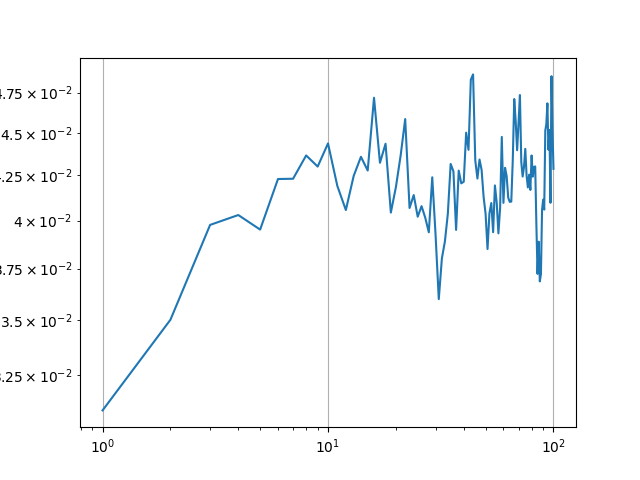

In [25]:
fig,ax=plt.subplots()

ax.loglog(imsd1)
ax.grid()
#ax.axis([1,100,1,100])

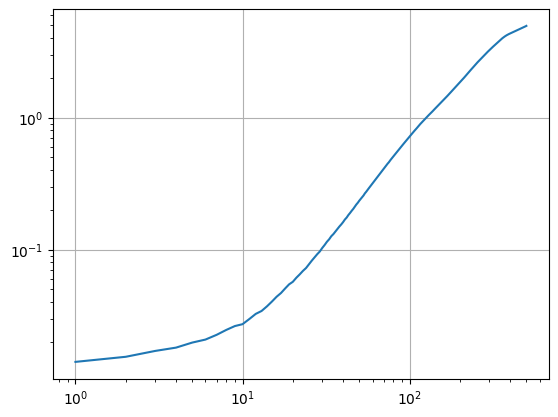

In [112]:
fig,ax=plt.subplots()

ax.loglog(imsd1)
ax.grid()
#ax.axis([1,100,1,100])

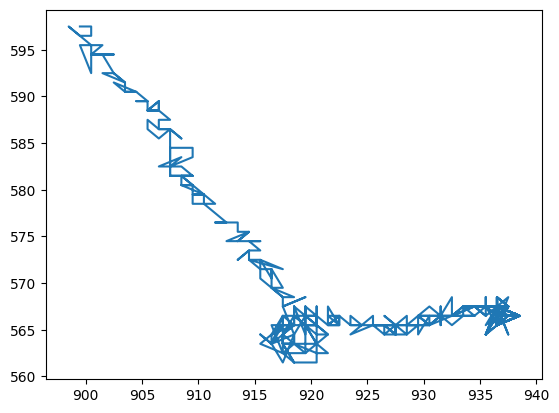

In [124]:
fig,ax= plt.subplots()
ax.plot(t1.x,t1.y)
#ax,pol,df.y)

# Verify results

In [133]:
testFileName = locatedFileNames[-12]
print(testFileName)
df1 = pd.read_csv(testFileName)
videoFileName = testFileName[:-25]
video = cv2.VideoCapture(videoFileName)

D:\Matan\20221217\fronters53passive28cm\C0505.MP4_locatedFull_20230106.csv


In [136]:
plt.ioff()
fig1 = plt.figure()
ax1 = fig1.gca()
#ax.imshow(frame,cmap='Greys')
plt.ion()
#fig1.canvas

In [137]:
#fig,ax = plt.subplots()
@interact(frameNum=frameRange)#df.frame.values)
def drawPassiveParticleOnFrame(frameNum):
    
    dff =df[df1.frame==frameNum]
    
    x,y,r = dff.x.values,dff.y.values,dff.r.values
    
    circles = [[x,y,r]]
    frame  = captureFrame(video,frameNum)
    img = frame#cropImage(frame,x0,y0,width0,height0)
    ax1.cla()
    ax1.imshow(img)
    drawCirclesDf(dff,ax1)
    
    #ax.imshow(img, cmap='Greys')
    
HBox([fig1.canvas])

interactive(children=(Dropdown(description='frameNum', options=(0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 2…

TraitError: The 'children' trait of a HBox instance contains an Instance of a TypedTuple which expected a Widget, not the FigureCanvasAgg at '0x19c8121d820'.

# Archive

In [13]:
fileName

'D:\\Matan\\20221218\\aligner53passive28cm\\C0510.MP4'

#### Using dynamic cropping: crop a square around the the circle and find next circle in that proximity

In [16]:
%%time

data = {'frame':[],'x':[],'y':[],'r':[]}
columns = ['frame','x','y','r']
df = pd.DataFrame(data=data,columns=columns)

boxSize = int(1.5*(2*radiusMax))
wc,hc = boxSize,boxSize
xc,yc = int(958-boxSize/2),int(548-boxSize/2)


video.set(cv2.CAP_PROP_POS_FRAMES, frameMin)

for frameNum in frameRange:
    
    #video.grab()#captureFrame(video,frameNum)
    ret, img = video.read()
    if(ret): #if succesfffuly read an image
        frameNum = video.get(cv2.CAP_PROP_POS_FRAMES)
        #imgRed = img[:,:,0]

        imgCropped = cropImage(img,xc,yc,wc,hc)

        imgE = cv2.Canny(imgCropped,threshMin,threshMax)

        circles = detectCircles(imgE,radiusMin, radiusMax,param1,param2)

        if circles is not None:        
            dft = circlesToDataFrame(circles,frameNum)
            dft['x'] = dft['x']+xc
            dft['y'] = dft['y']+yc

            df = pd.concat([df,dft],ignore_index=True)

            xc = int(xc+circles[0][0][0]-wc/2)
            yc = int(yc+circles[0][0][1]-hc/2)



CPU times: total: 6.67 s
Wall time: 1.17 s


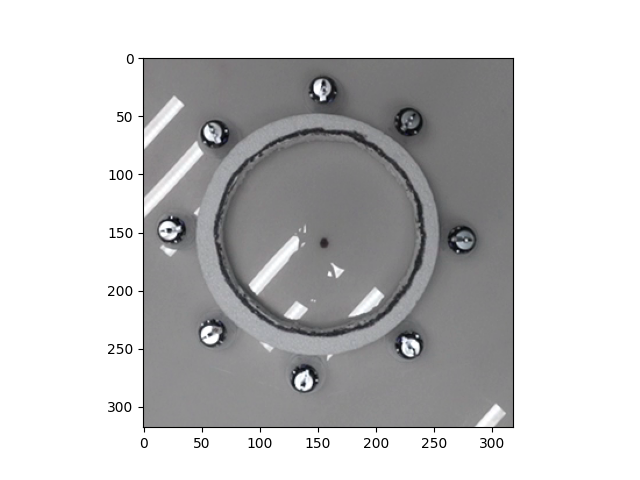

In [18]:
frameNum = frameMin
xc=int(958-wc/2)
yc = int(548-wc/2)
fig,ax= plt.subplots()
img = captureFrame(video,frameNum)
#imgRed = img[:,:,0]
#imgCropped = cropImage(imgRed,x0,y0,width0,height0)
imgCropped = cropImage(img,xc,yc,wc,hc)
imgE = cv2.Canny(imgCropped,threshMin,threshMax)

ax.imshow(imgCropped)
#drawCircles(circles,plt.gca())

In [19]:
plt.ioff()
fig1 = plt.figure()
ax1 = fig1.gca()
#ax.imshow(frame,cmap='Greys')
plt.ion()
#fig1.canvas

In [20]:
#fig,ax = plt.subplots()
@interact(frameNum=frameRange)#df.frame.values)
def drawPassiveParticleOnFrame(frameNum):
    
    dff =df[df.frame==frameNum]
    
    x,y,r = dff.x.values,dff.y.values,dff.r.values
    
    circles = [[x,y,r]]
    frame  = captureFrame(video,frameNum)
    img = frame#cropImage(frame,x0,y0,width0,height0)
    ax1.cla()
    ax1.imshow(img)
    drawCirclesDf(dff,ax1)
    
    #ax.imshow(img, cmap='Greys')
    
HBox([fig1.canvas])

interactive(children=(Dropdown(description='frameNum', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

In [ ]:
t = tp.link(df,search_range=20,memory=10)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [31]:
t1 = tp.filter_stubs(t,threshold=1000)

In [32]:
t1 = df.copy()
t1['particle']=0

In [33]:
imsd = tp.imsd(t1,fps = fps,mpp=pixelSize, max_lagtime=20000)

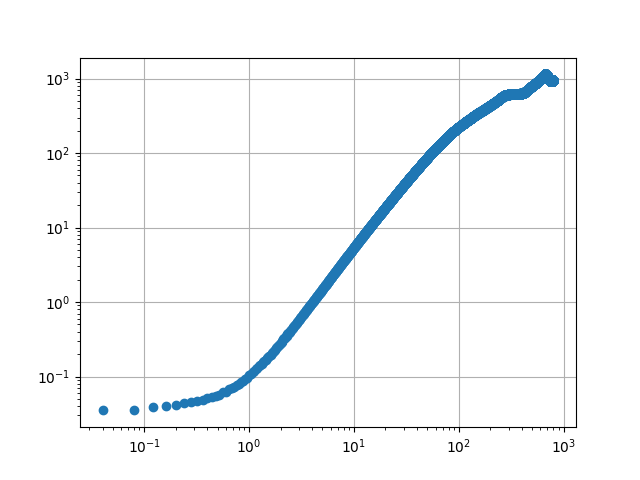

In [34]:
fig,ax = plt.subplots()
ax.loglog(imsd,'o')
ax.grid()

In [133]:
0.05**0.5

0.22360679774997896

In [55]:
#for optimizing params1 and param2
xSTD,ySTD,rSTD = [],[],[]
params1,params2 = [],[]


In [80]:
0.3**2

0.09

In [214]:
%%time

minFrame = 250
frameSkip = 1
frameMax = minFrame+2000#300#frameCount#minFrame+3*60*24

#for cargo:
#outer Radius
minRadius = 102#102
maxRadius = 105#105

#inner Radius
minRadius = 183#86
maxRadius = 190#90

param1 = 25#100#25#35#30#25#25
param2 = 20#35
#for robots:
#minRadius = 7
#maxRadius = 15
#param1 = 30
#param2 = 25

frameRange = range(minFrame,frameMax,frameSkip)
circlesAll = []
framesTracked = []
data = {'frame':[],'x':[],'y':[],'r':[]}
#dtypes = 

#data = np.array([(), (), (),()],
#               dtype=[('frame', 'int32'), ('x', 'float32'), ('y', 'float32'),('r','float32')])

columns = ['frame','x','y','r']
df = pd.DataFrame(data=data,columns=columns)

for frameNum in frameRange:
    frame = captureFrame(video,frameNum)
    frameProc = preProcessFrame(frame)
    #Increase resolution for "sub-pixel" accuracy on circle detection
    res = cv2.resize(frameProc, dsize=(int(width*2), int(height*2)), interpolation=cv2.INTER_CUBIC)
    circles = detectCircles(res,minRadius,maxRadius,param1,param2)
    #circles = detectCircles(frameProc,minRadius,maxRadius,param1,param2)
    
    
    if circles is not None:
        circlesAll.append(circles)
        framesTracked.append(frameNum)
        x,y,r = parseCircles(circles)
        data = {'frame':[int(frameNum)]*len(circles),'x':x,'y':y,'r':r}
        dft = pd.DataFrame(data = data)
        df = pd.concat([df,dft],ignore_index=True)
    
df = df.astype({"frame": int})

CPU times: total: 49min 15s
Wall time: 8min 13s


In [215]:
df

,frame,x,y,r
0,250,1922.5,1145.5,185.000000
1,251,1921.5,1146.5,184.899994
2,252,1921.5,1149.5,185.000000
3,253,1921.5,1147.5,183.899994
4,254,1921.5,1148.5,184.899994
...,...,...,...,...
1995,2245,2276.5,1176.5,183.600006
1996,2246,2277.5,1176.5,183.600006
1997,2247,2275.5,1176.5,184.100006
1998,2248,2275.5,1176.5,183.899994


In [58]:
df.to_csv(fileName+'_locatedFull_20221214.csv')

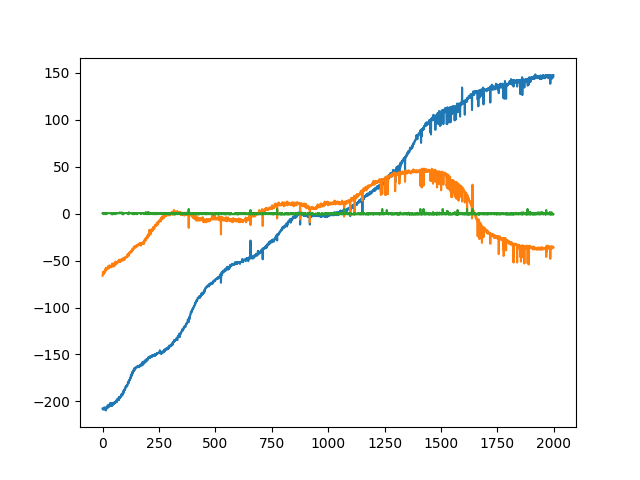

In [216]:
fig,ax = plt.subplots()

ax.plot(df.x-df.x.mean())
ax.plot(df.y-df.y.mean())
ax.plot(df.r-df.r.mean())
#ax.plot(np.diff(df.frame))

In [218]:
#fig,ax = plt.subplots()
@interact(frameNum=df.frame.values)
def drawPassiveParticleOnFrame(frameNum):
    
    dff =df[df.frame==frameNum]
    
    x,y,r = dff.x.values,dff.y.values,dff.r.values
    
    circles = [[x,y,r]]
    frame  = captureFrame(video,frameNum)
    ax.cla()
    ax.imshow(frame)
    drawCirclesDf(dff/2,ax)
    
    #ax.imshow(img, cmap='Greys')
    
HBox([fig.canvas])

interactive(children=(Dropdown(description='frameNum', options=(250, 251, 252, 253, 254, 255, 256, 257, 258, 2…

In [219]:
dfc=df.copy()
dfc.frame = df.frame/frameSkip
dfc = dfc.astype({"frame": int})

In [226]:

t = tp.link(dfc,search_range=10,memory=5)
t = tp.filter_stubs(t,threshold=100)

Frame 1748: 1 trajectories present.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [227]:
mpp = arenaSizeCm/arenaSizePixels #[cm/pixel]
mpp = arenaSizeCm/arenaSizePixels/2 #[cm/pixel]
imsd = tp.imsd(t,fps=fps/frameSkip,mpp=mpp,max_lagtime=30000)

In [171]:
imsd.to_csv(fileName+'MSDxxx20221214.csv')

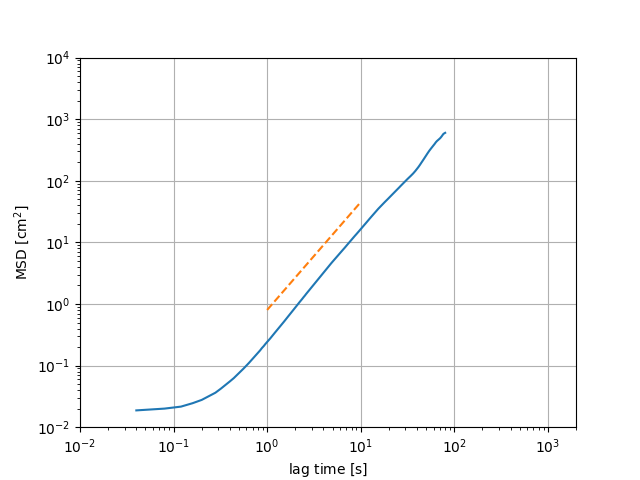

In [228]:
fig,ax = plt.subplots()
ax.loglog(imsd.index,imsd,label='msd')
#ax.plot(df.frame,df.x)
#ax.plot(df.frame,df.y)
x = np.linspace(1,10,10)
y = 0.08E1*x**1.75
ax.loglog(x,y,'--',label='1.75')

ax.axis([0.01,2000,0.01,1E4])
ax.grid()

ax.set_xlabel(r'lag time $\left[\rm{s}\right]$')
ax.set_ylabel(r'MSD $\left[\rm{cm}^2\right]$')

fig.savefig('MSDC0492__.png',bbox_inches='tight')

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

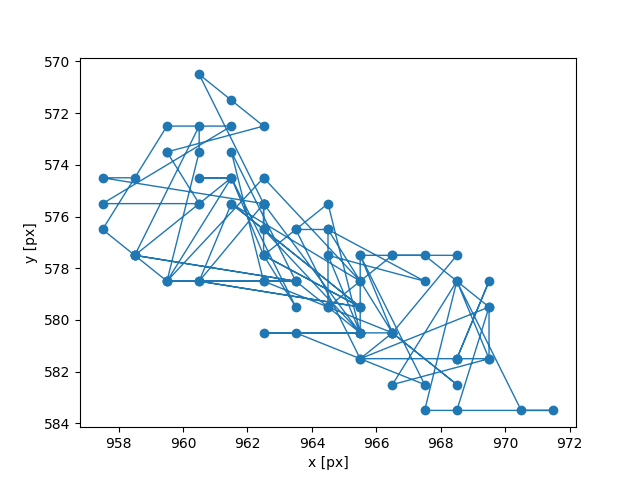

In [156]:
fig,ax=plt.subplots()

tp.plot_traj(t,ax=ax,plot_style={'marker':'o'})

In [276]:
params1.append(param1)
params2.append(param2)
xSTD.append(df.x.std())
ySTD.append(df.y.std())
rSTD.append(df.r.std())

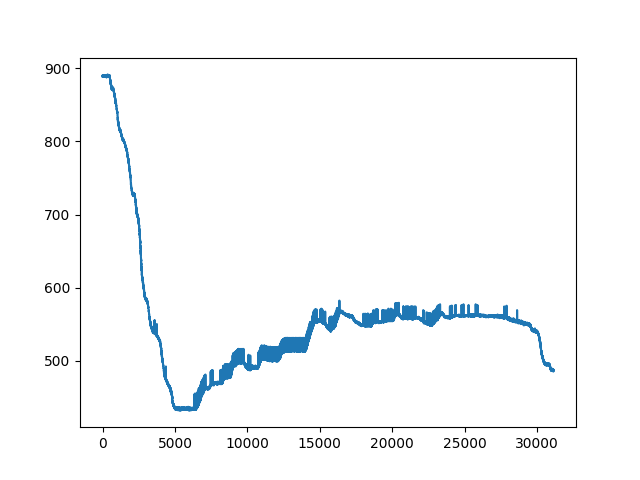

In [24]:
fig,ax=plt.subplots()
ax.plot(t.x)

In [310]:
75**2

5625

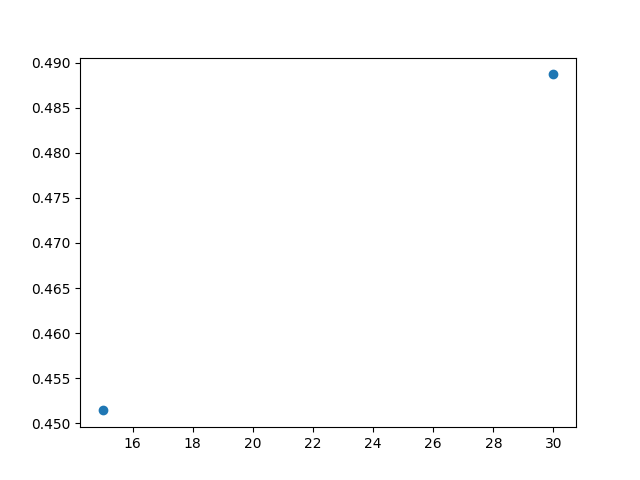

In [173]:
fig,ax = plt.subplots()
ax.plot(params1,rSTD,'o')

In [174]:
rSTD.append(df.r.std())

In [117]:
len(frameRange)

20

In [118]:
pwd

'D:\\Eden\\analysis\\sandbox'

(0.0, 264.22018348623857, 0.0, 148.6238532110092)

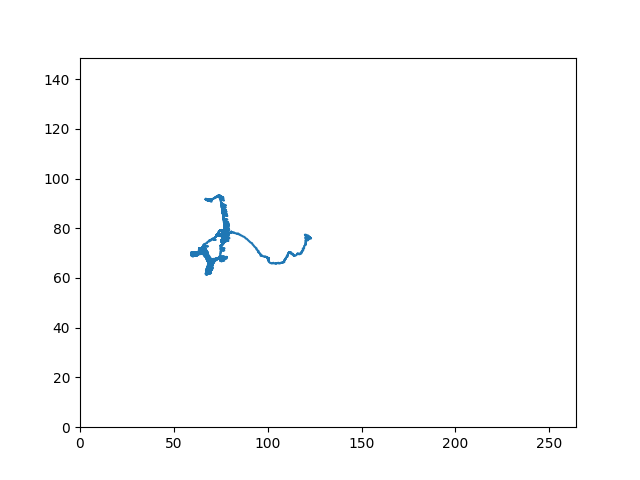

In [234]:
fig,ax = plt.subplots()
x,y=df.x,df.y

ax.plot(x*mpp,y*mpp)
ax.axis([0,width*mpp,0,height*mpp])
#plt.show()

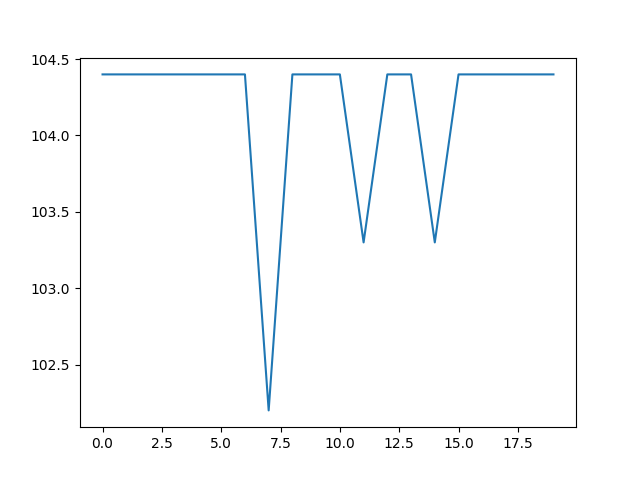

In [258]:
t.head()

,frame,x,y,r,particle
0,500,887.5,554.5,103.300003,0
1,501,887.5,553.5,103.300003,0
2,502,886.5,554.5,104.400002,0
3,503,887.5,555.5,104.400002,0
4,504,887.5,554.5,103.300003,0


In [259]:
t.frame.max()

699

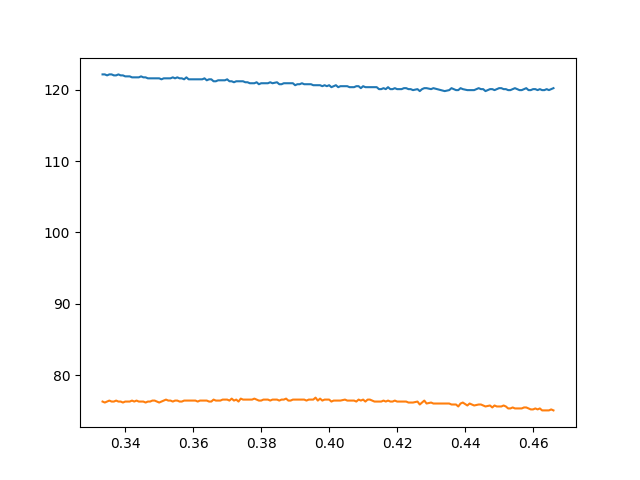

In [261]:
fig,ax = plt.subplots()
#ax.loglog(imsd.index,imsd)
frameToMin = 1/fps/60
ax.plot(df.frame*frameToMin,df.x*mpp)
ax.plot(df.frame*frameToMin,df.y*mpp)

In [255]:
150/1080

0.1388888888888889

In [209]:
cv2.imwrite('frame.png',frame)

True

C:\Users\User\AppData\Local\Temp\ipykernel_34948\1809963792.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots()


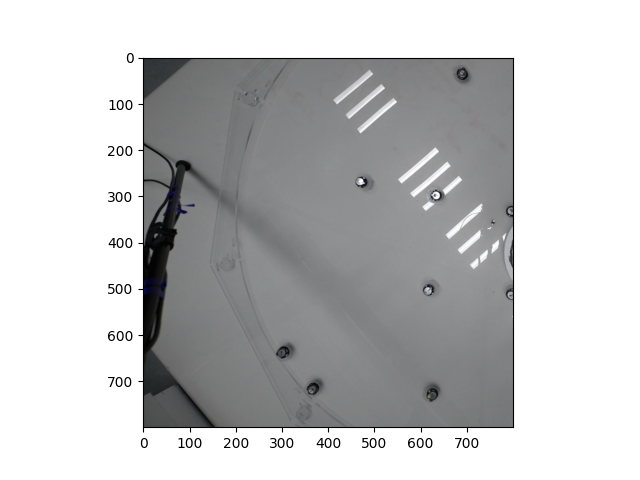

In [74]:
fig,ax=plt.subplots()
ax.imshow(img[200:1000,200:1000,:])
fig.savefig('figname.png',dpi='figure')

# Archive

### Use static cropping

In [135]:
'''%%time

data = {'frame':[],'x':[],'y':[],'r':[]}
columns = ['frame','x','y','r']
df = pd.DataFrame(data=data,columns=columns)
for frameNum in frameRange:
    
    img = captureFrame(video,frameNum)
    imgRed = img[:,:,0]
    imgCropped = cropImage(imgRed,x0,y0,width0,height0)
    
    imgE = cv2.Canny(imgCropped,threshMin,threshMax)

    circles = detectCircles(imgE,radiusMin, radiusMax,param1,param2)
    
    if circles is not None:        
        dft = circlesToDataFrame(circles)
        df = pd.concat([df,dft],ignore_index=True)
'''

CPU times: total: 38min 51s
Wall time: 5min 49s


In [87]:
pwd

'C:\\Users\\User\\Documents\\Eden\\locate_git_code'